# Steepener Strategy
Jinpeng Wei

Executive Summary: This projects aims to model the "steepener" strategy to trade on the yield curve spread between the 2-year and 10-year U.S. Treasury bonds for the time period from 1983 to 2024. We use the beta and tau values from the dataset to calculate yields using the Nelson-Siegel-Svensson model, and calculate metrics such as the DV01 and the hedge ratio. The stretegy starts with an initial value of $1 million and rebalances weekly to maintain a DV01 neutral position. Over time, the returns from the trades are added to the capital. We then decompose and plot the components of the strategy’s return such as the total, spread, convexity, residual and time returns. Finally we compare the cumulative total returns for the 10% margin requirement against a 2% margin requirement.


Introduction:
We will provide an analysis of the steepener strategy in yield curve spread trading, that capitalizes on a steepening yield curve. The idea is to take a long position in shorter-term bonds while simultaneously taking a short position in longer-term bonds. The strategy aims to profit when the yield spread between long-term and short-term bonds widens.

Our analysis will cover the following key aspects:
1. Yield: From the daily U.S. Treasury yield curve we utilize the betas and Tau metrics and use the Nelson-Siegel-Svensson model to compute zero-coupon bond yields across different maturities, capturing the level, slope, and curvature of the yield curve over time.
2. Risk Management and Capital Allocation: In order to maintain DV01-neutral, we’ve set up a 10% capital requirement and will need to compute a hedge ratio to effectively balance the interest rate risk between both positions.
3. Return Attribution: Weekly returns from the steepener strategy are separated into spread return, convexity return, time return, and residual, allowing for a detailed examination of the factors driving cumulative returns. We will further explain how this contributes to the total return, highlighting the role of changes in yield spreads, unhedged convexity, and interest earned on the cash position.
* Convexity: Our analysis will evaluates how convexity impacts the outcomes of the steepener, especially when yield changes are not fully offset by bond positions.





We download data and store it in a dataframe. We extract the beta and tau values from 1983-12-30 to 2024-10-04 and resample for every friday.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


data = pd.read_csv('/content/sample_data/feds200628.csv', index_col = 0, header = 7)
data = data.iloc[5882:16514,[0,1,2,3,-2,-1]]
data.index = pd.to_datetime(data.index)
weeklydata = data.resample('W-FRI',origin='1983-12-30').first()
weeklydata

,BETA0,BETA1,BETA2,BETA3,TAU1,TAU2
Date,,,,,,
1983-12-30,11.838493,-2.805414,-618.567862,619.829427,1.626814,1.627871
1984-01-06,11.917554,-2.907937,-618.582602,619.815210,1.627005,1.627888
1984-01-13,11.766698,-2.803712,-618.574967,619.823069,1.618979,1.620622
1984-01-20,11.485792,-2.557485,-618.610129,619.787714,1.653156,1.655665
1984-01-27,11.537386,-2.501347,-618.682060,619.716702,1.588739,1.591200
...,...,...,...,...,...,...
2024-09-06,4.710505,0.823191,-2.020083,-2.907927,0.894779,3.232259
2024-09-13,4.596096,1.097561,-2.653892,-2.945598,0.795099,3.225970
2024-09-20,4.542627,1.034434,-2.755772,-2.993293,0.745185,3.257553


First we initialize the result list to store our values, cum variables to store the accumulated values and set up initial capital and margin. Then we use the equation of margin requirement and duration immunization to calculate the front and back legs. We also calculate the duration and convexity of front and back legs for further use.

In [ ]:
#Initialize
result = [1]
result_s = [0]
result_c = [0]
result_t = [0]
result_r = [0]
margin = 0.1
capital = 1
cum_s = 0
cum_c = 0
cum_t = 0
cum_r = 0


#Start trading position on 1983-12-30
#Calculate 2Y, 10Y, 1W yield rate
rdata = weeklydata.iloc[0]
BETA0 =rdata['BETA0']
BETA1 =rdata['BETA1']
BETA2 =rdata['BETA2']
BETA3 =rdata['BETA3']
TAU1 = rdata['TAU1']
TAU2 = rdata['TAU2']

t1 = 2 / TAU1
t2 = 2 / TAU2
r2 = (BETA0 + BETA1 * (1 - np.exp(-t1)) / t1 + BETA2 * ((1 - np.exp(-t1)) / t1 - np.exp(-t1)) + BETA3 * ((1 - np.exp(-t2)) / t2 - np.exp(-t2))) / 100

t1 = 10 / TAU1
t2 = 10 / TAU2
r10 = (BETA0 + BETA1 * (1 - np.exp(-t1)) / t1 + BETA2 * ((1 - np.exp(-t1)) / t1 - np.exp(-t1)) + BETA3 * ((1 - np.exp(-t2)) / t2 - np.exp(-t2))) / 100

t1 = 1 / (52 * TAU1)
t2 = 1 / (52 * TAU2)
rw = (BETA0 + BETA1 * (1 - np.exp(-t1)) / t1 + BETA2 * ((1 - np.exp(-t1)) / t1 - np.exp(-t1)) + BETA3 * ((1 - np.exp(-t2)) / t2 - np.exp(-t2))) / 100

#Calculate starting position using margin requirement and duration
matrix_1 = np.array([[1, -1],[2 * (1 + r2) ** (-3), 10 * (1 + r10) ** (-11)]])
matrix_2 = np.array([[capital / margin],[0]])
position = np.linalg.inv(matrix_1) @ matrix_2
front = position[0,0]
back = position[1,0]
position_value = front * (1 + r2) ** (-2) + back * (1 + r10) ** (-10)
front_duration = front * 2 * (1 + r2) ** (-3)
back_duration = back * 10 * (1 + r10) ** (-11)
front_convexity = front * 2 * 3 * (1 + r2) ** (-4)
back_convexity = back * 10 * 11 * (1 + r10) ** (-12)
passage_value = front * (1 + r2) ** (-2 + 1 / 52) + back * (1 + r10) ** (-10 + 1 / 52) - front * (1 + r2) ** (-2) - back * (1 + r10) ** (-10)

We rebalance every week. The cash position equals the initial capital plus cash earned on short position minus cash paid on long position. We then use the interest earned on cash position and bond price changes to calculate the new capital. We also using duration and convexity previously calculated and the yield rate changes now to derive spread returns, convexity returns, time returns and residual returns.

In [ ]:
for i in range(1,2127):
    #Calculate cash position and weekly interest earned
    capital_old = capital
    capital = capital - position_value
    interest = capital * (1 + rw) ** (1 / 52) - capital
    capital = capital + interest

    #Calculate 2Y, 10Y, 1W yield rate
    rdata = weeklydata.iloc[i]
    BETA0 =rdata['BETA0']
    BETA1 =rdata['BETA1']
    BETA2 =rdata['BETA2']
    BETA3 =rdata['BETA3']
    TAU1 = rdata['TAU1']
    TAU2 = rdata['TAU2']

    r2_old = r2
    r10_old = r10

    t1 = 2 / TAU1
    t2 = 2 / TAU2
    r2 = (BETA0 + BETA1 * (1 - np.exp(-t1)) / t1 + BETA2 * ((1 - np.exp(-t1)) / t1 - np.exp(-t1)) + BETA3 * ((1 - np.exp(-t2)) / t2 - np.exp(-t2))) / 100

    t1 = 10 / TAU1
    t2 = 10 / TAU2
    r10 = (BETA0 + BETA1 * (1 - np.exp(-t1)) / t1 + BETA2 * ((1 - np.exp(-t1)) / t1 - np.exp(-t1)) + BETA3 * ((1 - np.exp(-t2)) / t2 - np.exp(-t2))) / 100

    t1 = 1 / (52 * TAU1)
    t2 = 1 / (52 * TAU2)
    rw = (BETA0 + BETA1 * (1 - np.exp(-t1)) / t1 + BETA2 * ((1 - np.exp(-t1)) / t1 - np.exp(-t1)) + BETA3 * ((1 - np.exp(-t2)) / t2 - np.exp(-t2))) / 100

    # Calculate position value and capital now
    spread = -front_duration * (r2 - r2_old) - back_duration * (r10 - r10_old)
    convexity = 0.5 * front_convexity * (r2 - r2_old) ** 2 + 0.5 * back_convexity * (r10 - r10_old) ** 2
    time = passage_value + interest
    residual = front * (1 + r2) ** (-2 + 1 /52) + back * (1 + r10) ** (-10 + 1 / 52) - position_value - spread - convexity - passage_value

    cum_s += spread
    cum_c += convexity
    cum_t += time
    cum_r += residual

    position_value = front * (1 + r2) ** (-2 + 1 /52) + back * (1 + r10) ** (-10 + 1 / 52)
    capital = capital + position_value

    result.append(capital)
    result_s.append(cum_s)
    result_c.append(cum_c)
    result_t.append(cum_t)
    result_r.append(cum_r)

    #Calculate new position using margin requirement and duration based on capital now
    matrix_1 = np.array([[1, -1],[2 * (1 + r2) ** (-3), 10 * (1 + r10) ** (-11)]])
    matrix_2 = np.array([[capital / margin],[0]])
    position = np.linalg.inv(matrix_1) @ matrix_2
    front = position[0,0]
    back = position[1,0]
    position_value = front * (1 + r2) ** (-2) + back * (1 + r10) ** (-10)
    front_duration = front * 2 * (1 + r2) ** (-3)
    back_duration = back * 10 * (1 + r10) ** (-11)
    front_convexity = front * 2 * 3 * (1 + r2) ** (-4)
    back_convexity = back * 10 * 11 * (1 + r10) ** (-12)
    passage_value = front * (1 + r2) ** (-2 + 1 / 52) + back * (1 + r10) ** (-10 + 1 / 52) - front * (1 + r2) ** (-2) - back * (1 + r10) ** (-10)

We close all our positions on 2024-09-30 using the same method as above

In [ ]:
# Unwinding the trade on 2024-09-30

#Calculate cash position and weekly interest earned
capital_old = capital
capital = capital - position_value
interest = capital * (1 + rw) ** (1 / 52) - capital
capital = capital + interest

#Calculate 2Y, 10Y, 1W yield rate
rdata = data.loc['2024-09-30']
BETA0 =rdata['BETA0']
BETA1 =rdata['BETA1']
BETA2 =rdata['BETA2']
BETA3 =rdata['BETA3']
TAU1 = rdata['TAU1']
TAU2 = rdata['TAU2']

r2_old = r2
r10_old = r10

t1 = 2 / TAU1
t2 = 2 / TAU2
r2 = (BETA0 + BETA1 * (1 - np.exp(-t1)) / t1 + BETA2 * ((1 - np.exp(-t1)) / t1 - np.exp(-t1)) + BETA3 * ((1 - np.exp(-t2)) / t2 - np.exp(-t2))) / 100

t1 = 10 / TAU1
t2 = 10 / TAU2
r10 = (BETA0 + BETA1 * (1 - np.exp(-t1)) / t1 + BETA2 * ((1 - np.exp(-t1)) / t1 - np.exp(-t1)) + BETA3 * ((1 - np.exp(-t2)) / t2 - np.exp(-t2))) / 100

t1 = 1 / (52 * TAU1)
t2 = 1 / (52 * TAU2)
rw = (BETA0 + BETA1 * (1 - np.exp(-t1)) / t1 + BETA2 * ((1 - np.exp(-t1)) / t1 - np.exp(-t1)) + BETA3 * ((1 - np.exp(-t2)) / t2 - np.exp(-t2))) / 100

# Calculate position value and capital now
spread = -front_duration * (r2 - r2_old) - back_duration * (r10 - r10_old)
convexity = 0.5 * front_convexity * (r2 - r2_old) ** 2 + 0.5 * back_convexity * (r10 - r10_old) ** 2
time = passage_value + interest
residual = front * (1 + r2) ** (-2 + 1 /52) + back * (1 + r10) ** (-10 + 1 / 52) - position_value - spread - convexity - passage_value

cum_s += spread
cum_c += convexity
cum_t += time
cum_r += residual

position_value = front * (1 + r2) ** (-2 + 1 /52) + back * (1 + r10) ** (-10 + 1 / 52)
capital = capital + position_value
result.append(capital)
result_s.append(cum_s)
result_c.append(cum_c)
result_t.append(cum_t)
result_r.append(cum_r)

We store all the values and cumulated values in dataframe columns and plot the results

In [ ]:
weeklydata['total'] = result
weeklydata['total'] = weeklydata['total'] - 1
weeklydata['spread'] = result_s
weeklydata['convexity'] = result_c
weeklydata['time'] = result_t
weeklydata['residual'] = result_r
weeklydata

,BETA0,BETA1,BETA2,BETA3,TAU1,TAU2,total,spread,convexity,time,residual
Date,,,,,,,,,,,
1983-12-30,11.838493,-2.805414,-618.567862,619.829427,1.626814,1.627871,0.000000,0.000000,0.000000,0.000000,0.000000
1984-01-06,11.917554,-2.907937,-618.582602,619.815210,1.627005,1.627888,0.005683,0.003077,-0.000011,0.002603,0.000014
1984-01-13,11.766698,-2.803712,-618.574967,619.823069,1.618979,1.620622,0.009872,0.004734,-0.000034,0.005240,-0.000068
1984-01-20,11.485792,-2.557485,-618.610129,619.787714,1.653156,1.655665,0.011459,0.004048,-0.000195,0.007837,-0.000231
1984-01-27,11.537386,-2.501347,-618.682060,619.716702,1.588739,1.591200,0.010703,0.000755,-0.000198,0.010313,-0.000167
...,...,...,...,...,...,...,...,...,...,...,...
2024-09-06,4.710505,0.823191,-2.020083,-2.907927,0.894779,3.232259,2.277747,-0.873297,-0.746885,3.915178,-0.017250
2024-09-13,4.596096,1.097561,-2.653892,-2.945598,0.795099,3.225970,2.308784,-0.838856,-0.747057,3.912756,-0.018059
2024-09-20,4.542627,1.034434,-2.755772,-2.993293,0.745185,3.257553,2.323638,-0.819766,-0.747105,3.909006,-0.018498


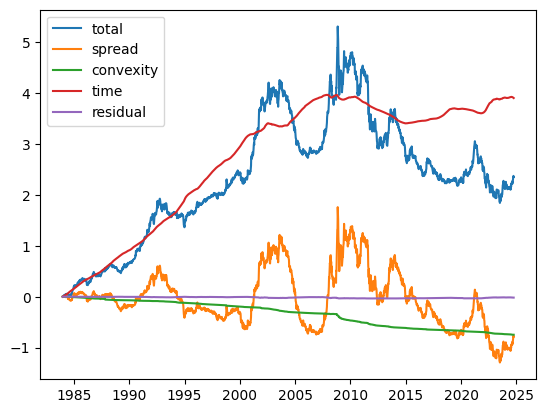

In [ ]:
plt.plot(weeklydata.index, weeklydata[['total','spread','convexity','time','residual']], label = ['total','spread','convexity','time','residual'])
plt.legend()

We assume we have a constant position on the back leg, so we use duration immunization to derive our front leg. Then we calculated convexity of both legs and derive the portfolio convexity.

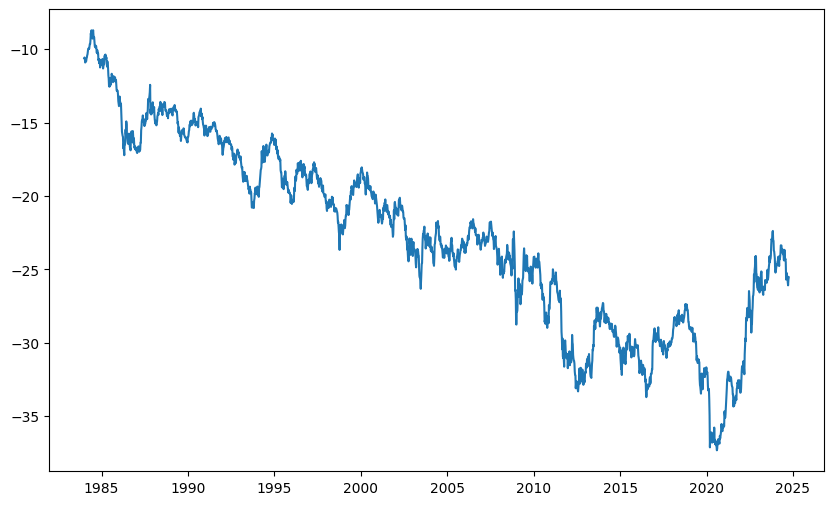

In [ ]:
delta_r = 10 / 10000
result_2 = []
for i in range(2127):
    rdata = weeklydata.iloc[i]
    BETA0 =rdata['BETA0']
    BETA1 =rdata['BETA1']
    BETA2 =rdata['BETA2']
    BETA3 =rdata['BETA3']
    TAU1 = rdata['TAU1']
    TAU2 = rdata['TAU2']

    t1 = 2 / TAU1
    t2 = 2 / TAU2
    r2 = (BETA0 + BETA1 * (1 - np.exp(-t1)) / t1 + BETA2 * ((1 - np.exp(-t1)) / t1 - np.exp(-t1)) + BETA3 * ((1 - np.exp(-t2)) / t2 - np.exp(-t2))) / 100

    t1 = 10 / TAU1
    t2 = 10 / TAU2
    r10 = (BETA0 + BETA1 * (1 - np.exp(-t1)) / t1 + BETA2 * ((1 - np.exp(-t1)) / t1 - np.exp(-t1)) + BETA3 * ((1 - np.exp(-t2)) / t2 - np.exp(-t2))) / 100

    front_duration = 2 * (1 + r2) ** (-3)
    back_duration = 10 * (1 + r10) ** (-11)
    back = -1000000
    front = - back * back_duration / front_duration
    front_convexity = front * 2 * 3 * (1 + r2) ** (-4)
    back_convexity = back * 10 * 11 * (1 + r10) ** (-12)
    convexity = 0.5 * front_convexity * delta_r ** 2 + 0.5 * back_convexity * delta_r ** 2
    result_2.append(convexity)

rdata = data.loc['2024-09-30']
BETA0 =rdata['BETA0']
BETA1 =rdata['BETA1']
BETA2 =rdata['BETA2']
BETA3 =rdata['BETA3']
TAU1 = rdata['TAU1']
TAU2 = rdata['TAU2']

t1 = 2 / TAU1
t2 = 2 / TAU2
r2 = (BETA0 + BETA1 * (1 - np.exp(-t1)) / t1 + BETA2 * ((1 - np.exp(-t1)) / t1 - np.exp(-t1)) + BETA3 * ((1 - np.exp(-t2)) / t2 - np.exp(-t2))) / 100

t1 = 10 / TAU1
t2 = 10 / TAU2
r10 = (BETA0 + BETA1 * (1 - np.exp(-t1)) / t1 + BETA2 * ((1 - np.exp(-t1)) / t1 - np.exp(-t1)) + BETA3 * ((1 - np.exp(-t2)) / t2 - np.exp(-t2))) / 100

front_duration = 2 * (1 + r2) ** (-3)
back_duration = 10 * (1 + r10) ** (-11)
back = -1000000
front = - back * back_duration / front_duration
front_convexity = front * 2 * 3 * (1 + r2) ** (-4)
back_convexity = back * 10 * 11 * (1 + r10) ** (-12)
convexity = 0.5 * front_convexity * delta_r ** 2 + 0.5 * back_convexity * delta_r ** 2
result_2.append(convexity)
plt.figure(figsize=(10, 6))
plt.plot(weeklydata.index,result_2)

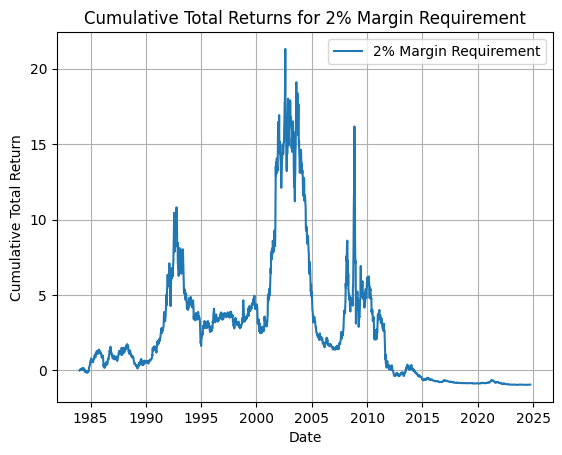

In [ ]:
#Initialize
result = [1]
result_s = [0]
result_c = [0]
result_t = [0]
result_r = [0]
margin = 0.02
capital = 1
cum_s = 0
cum_c = 0
cum_t = 0
cum_r = 0


#Start trading position on 1983-12-30
#Calculate 2Y, 10Y, 1W yield rate
rdata = weeklydata.iloc[0]
BETA0 =rdata['BETA0']
BETA1 =rdata['BETA1']
BETA2 =rdata['BETA2']
BETA3 =rdata['BETA3']
TAU1 = rdata['TAU1']
TAU2 = rdata['TAU2']

t1 = 2 / TAU1
t2 = 2 / TAU2
r2 = (BETA0 + BETA1 * (1 - np.exp(-t1)) / t1 + BETA2 * ((1 - np.exp(-t1)) / t1 - np.exp(-t1)) + BETA3 * ((1 - np.exp(-t2)) / t2 - np.exp(-t2))) / 100

t1 = 10 / TAU1
t2 = 10 / TAU2
r10 = (BETA0 + BETA1 * (1 - np.exp(-t1)) / t1 + BETA2 * ((1 - np.exp(-t1)) / t1 - np.exp(-t1)) + BETA3 * ((1 - np.exp(-t2)) / t2 - np.exp(-t2))) / 100

t1 = 1 / (52 * TAU1)
t2 = 1 / (52 * TAU2)
rw = (BETA0 + BETA1 * (1 - np.exp(-t1)) / t1 + BETA2 * ((1 - np.exp(-t1)) / t1 - np.exp(-t1)) + BETA3 * ((1 - np.exp(-t2)) / t2 - np.exp(-t2))) / 100

#Calculate starting position using margin requirement and duration
matrix_1 = np.array([[1, -1],[2 * (1 + r2) ** (-3), 10 * (1 + r10) ** (-11)]])
matrix_2 = np.array([[capital / margin],[0]])
position = np.linalg.inv(matrix_1) @ matrix_2
front = position[0,0]
back = position[1,0]
position_value = front * (1 + r2) ** (-2) + back * (1 + r10) ** (-10)
front_duration = front * 2 * (1 + r2) ** (-3)
back_duration = back * 10 * (1 + r10) ** (-11)
front_convexity = front * 2 * 3 * (1 + r2) ** (-4)
back_convexity = back * 10 * 11 * (1 + r10) ** (-12)
passage_value = front * (1 + r2) ** (-2 + 1 / 52) + back * (1 + r10) ** (-10 + 1 / 52) - front * (1 + r2) ** (-2) - back * (1 + r10) ** (-10)

for i in range(1,2127):
    #Calculate cash position and weekly interest earned
    capital_old = capital
    capital = capital - position_value
    interest = capital * (1 + rw) ** (1 / 52) - capital
    capital = capital + interest

    #Calculate 2Y, 10Y, 1W yield rate
    rdata = weeklydata.iloc[i]
    BETA0 =rdata['BETA0']
    BETA1 =rdata['BETA1']
    BETA2 =rdata['BETA2']
    BETA3 =rdata['BETA3']
    TAU1 = rdata['TAU1']
    TAU2 = rdata['TAU2']

    r2_old = r2
    r10_old = r10

    t1 = 2 / TAU1
    t2 = 2 / TAU2
    r2 = (BETA0 + BETA1 * (1 - np.exp(-t1)) / t1 + BETA2 * ((1 - np.exp(-t1)) / t1 - np.exp(-t1)) + BETA3 * ((1 - np.exp(-t2)) / t2 - np.exp(-t2))) / 100

    t1 = 10 / TAU1
    t2 = 10 / TAU2
    r10 = (BETA0 + BETA1 * (1 - np.exp(-t1)) / t1 + BETA2 * ((1 - np.exp(-t1)) / t1 - np.exp(-t1)) + BETA3 * ((1 - np.exp(-t2)) / t2 - np.exp(-t2))) / 100

    t1 = 1 / (52 * TAU1)
    t2 = 1 / (52 * TAU2)
    rw = (BETA0 + BETA1 * (1 - np.exp(-t1)) / t1 + BETA2 * ((1 - np.exp(-t1)) / t1 - np.exp(-t1)) + BETA3 * ((1 - np.exp(-t2)) / t2 - np.exp(-t2))) / 100

    # Calculate position value and capital now
    spread = -front_duration * (r2 - r2_old) - back_duration * (r10 - r10_old)
    convexity = 0.5 * front_convexity * (r2 - r2_old) ** 2 + 0.5 * back_convexity * (r10 - r10_old) ** 2
    time = passage_value + interest
    residual = front * (1 + r2) ** (-2 + 1 /52) + back * (1 + r10) ** (-10 + 1 / 52) - position_value - spread - convexity - passage_value

    cum_s += spread
    cum_c += convexity
    cum_t += time
    cum_r += residual

    position_value = front * (1 + r2) ** (-2 + 1 /52) + back * (1 + r10) ** (-10 + 1 / 52)
    capital = capital + position_value

    result.append(capital)
    result_s.append(cum_s)
    result_c.append(cum_c)
    result_t.append(cum_t)
    result_r.append(cum_r)

    #Calculate new position using margin requirement and duration based on capital now
    matrix_1 = np.array([[1, -1],[2 * (1 + r2) ** (-3), 10 * (1 + r10) ** (-11)]])
    matrix_2 = np.array([[capital / margin],[0]])
    position = np.linalg.inv(matrix_1) @ matrix_2
    front = position[0,0]
    back = position[1,0]
    position_value = front * (1 + r2) ** (-2) + back * (1 + r10) ** (-10)
    front_duration = front * 2 * (1 + r2) ** (-3)
    back_duration = back * 10 * (1 + r10) ** (-11)
    front_convexity = front * 2 * 3 * (1 + r2) ** (-4)
    back_convexity = back * 10 * 11 * (1 + r10) ** (-12)
    passage_value = front * (1 + r2) ** (-2 + 1 / 52) + back * (1 + r10) ** (-10 + 1 / 52) - front * (1 + r2) ** (-2) - back * (1 + r10) ** (-10)
    # Unwinding the trade on 2024-09-30

#Calculate cash position and weekly interest earned
capital_old = capital
capital = capital - position_value
interest = capital * (1 + rw) ** (1 / 52) - capital
capital = capital + interest

#Calculate 2Y, 10Y, 1W yield rate
rdata = data.loc['2024-09-30']
BETA0 =rdata['BETA0']
BETA1 =rdata['BETA1']
BETA2 =rdata['BETA2']
BETA3 =rdata['BETA3']
TAU1 = rdata['TAU1']
TAU2 = rdata['TAU2']

r2_old = r2
r10_old = r10

t1 = 2 / TAU1
t2 = 2 / TAU2
r2 = (BETA0 + BETA1 * (1 - np.exp(-t1)) / t1 + BETA2 * ((1 - np.exp(-t1)) / t1 - np.exp(-t1)) + BETA3 * ((1 - np.exp(-t2)) / t2 - np.exp(-t2))) / 100

t1 = 10 / TAU1
t2 = 10 / TAU2
r10 = (BETA0 + BETA1 * (1 - np.exp(-t1)) / t1 + BETA2 * ((1 - np.exp(-t1)) / t1 - np.exp(-t1)) + BETA3 * ((1 - np.exp(-t2)) / t2 - np.exp(-t2))) / 100

t1 = 1 / (52 * TAU1)
t2 = 1 / (52 * TAU2)
rw = (BETA0 + BETA1 * (1 - np.exp(-t1)) / t1 + BETA2 * ((1 - np.exp(-t1)) / t1 - np.exp(-t1)) + BETA3 * ((1 - np.exp(-t2)) / t2 - np.exp(-t2))) / 100

# Calculate position value and capital now
spread = -front_duration * (r2 - r2_old) - back_duration * (r10 - r10_old)
convexity = 0.5 * front_convexity * (r2 - r2_old) ** 2 + 0.5 * back_convexity * (r10 - r10_old) ** 2
time = passage_value + interest
residual = front * (1 + r2) ** (-2 + 1 /52) + back * (1 + r10) ** (-10 + 1 / 52) - position_value - spread - convexity - passage_value

cum_s += spread
cum_c += convexity
cum_t += time
cum_r += residual

position_value = front * (1 + r2) ** (-2 + 1 /52) + back * (1 + r10) ** (-10 + 1 / 52)
capital = capital + position_value
result.append(capital)
result_s.append(cum_s)
result_c.append(cum_c)
result_t.append(cum_t)
result_r.append(cum_r)
weeklydata['total'] = result
weeklydata['total'] = weeklydata['total'] - 1
weeklydata['spread'] = result_s
weeklydata['convexity'] = result_c
weeklydata['time'] = result_t
weeklydata['residual'] = result_r
plt.plot(
    weeklydata.index,
    weeklydata['total'],
    label="2% Margin Requirement"
    )
plt.xlabel("Date")
plt.ylabel("Cumulative Total Return")
plt.title("Cumulative Total Returns for 2% Margin Requirement")
plt.legend()
plt.grid(True)


### Conclusions:
In the previous work we were able to verify the different attributions in the return of a fixed income portfolio and verify certain characteristics of it:
- We verify how, despite having a portfolio neutral to interest rate risk (DV01), it generates its main return over time due to the interest accrual of the position. This is mainly due to the characteristics of the valuation process of fixed income instruments. We see that in second in importance is the steepening of the curve, which is the characteristic of our portfolio.
Finally, since the global financial crisis, it is possible to observe an increase in the relative importance of convexity in the returns. This is mainly due to the fact that movements in  curve became more severe, even increasing during the COVID pandemic.
- The risk generated by the convexity of the position became more negative through time, meanning a bigger sensitivity to big changes in the interest rate structure.
- The majority of the mean of total return came from time value, but the majority of the volatility of total return came from spread return.
- When we analized the decrease on margin requirement from 10% to 2%, we can see how a multiplier effect is generated in the returns. It is possible to verify that by being able to take a larger position with the same amount of cash, higher accumulated returns were generated. Also, this decrease generate less expenses in financing.  